# Disabling forking warning

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


# Installing required libraries

In [2]:
!pip install timm

# Loading required libraries

In [3]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from timm import create_model
from torch.utils.data import DataLoader

# Preprocessing the data, creating dataloaders and loading VIT for SVHN

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for pretrained models
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.SVHN(root='./data', split = 'train', download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.SVHN(root='./data', split = 'test', download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Step 2: Load Pretrained Vision Transformer (ViT) model and prepare for fine-tuning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model('vit_base_patch16_224', pretrained=True)

# Freeze the feature extractor backbone
for param in model.parameters():
    param.requires_grad = False

model.head = nn.Linear(model.head.in_features, 10)
model = model.to(device)

# Define the optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=3e-4)  # AdamW optimizer for ViT
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification

100%|██████████| 182040794/182040794 [00:09<00:00, 18980113.38it/s]


100%|██████████| 64275384/64275384 [00:04<00:00, 13886025.21it/s]


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# Visualising one image to see the effects of semantic and covariate shift

Training Images:
Test Images:


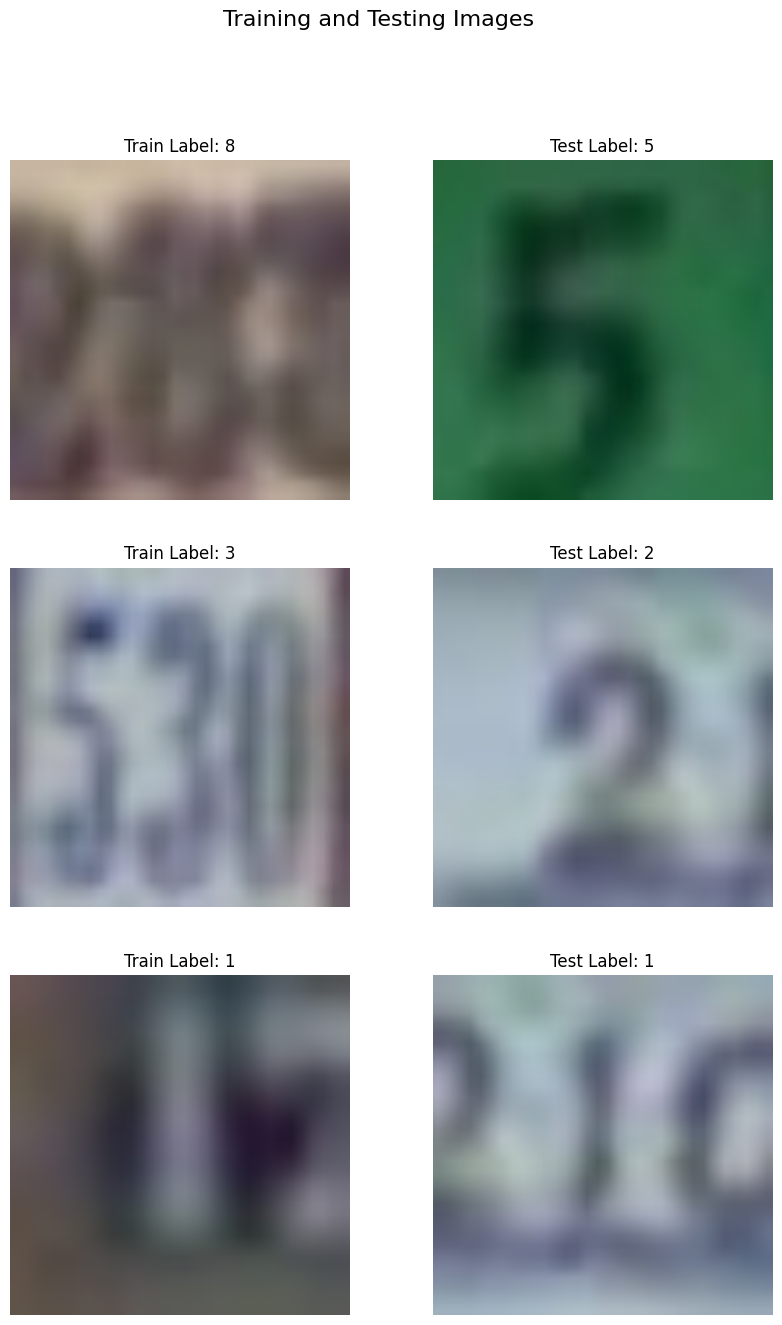

Zipped folders created for download:
Download train_images.zip and test_images.zip from the 'Files' tab in Kaggle.
Combined image saved as: ./combined_images.png


In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import shutil

# Function to unnormalize and plot an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    return np.transpose(img.numpy(), (1, 2, 0))  # Convert from C x H x W to H x W x C

# Function to save and show images
def show_and_save_images(data_loader, num_images=3):
    # Get one batch of images
    dataiter = iter(data_loader)
    images, labels = next(dataiter)

    # Store images and labels for display
    display_images = []
    for i in range(num_images):
        img = imshow(images[i])  # Prepare image for display
        display_images.append((img, labels[i].item()))  # Store image and label

    return display_images

# Define folders for saving images
train_images_folder = './train_images'
test_images_folder = './test_images'

# Show and save images from the training set
print("Training Images:")
train_display_images = show_and_save_images(trainloader)

# Show and save images from the test set
print("Test Images:")
test_display_images = show_and_save_images(testloader)

# Create a combined image
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
fig.suptitle('Training and Testing Images', fontsize=16)

# Plot training images
for i, (img, label) in enumerate(train_display_images):
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Train Label: {label}')

# Plot testing images
for i, (img, label) in enumerate(test_display_images):
    axes[i, 1].imshow(img)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Test Label: {label}')

# Set column titles
axes[0, 0].set_ylabel('Training Images', fontsize=14)
axes[0, 1].set_ylabel('Testing Images', fontsize=14)

# Save the combined image
combined_image_path = './combined_images.png'
plt.savefig(combined_image_path, bbox_inches='tight')
plt.show()

# Zip the folders for downloading
shutil.make_archive('train_images', 'zip', train_images_folder)
shutil.make_archive('test_images', 'zip', test_images_folder)

# Inform user about downloading
print("Zipped folders created for download:")
print("Download train_images.zip and test_images.zip from the 'Files' tab in Kaggle.")
print(f"Combined image saved as: {combined_image_path}")


# Training VIT

In [4]:
# Step 3: Fine-tune the model
num_epochs = 3  # Set to a small number for quick fine-tuning; can increase based on need

for epoch in range(3):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

Epoch [1/3], Batch [100], Loss: 2.2174

Epoch [1/3], Batch [200], Loss: 1.9729

Epoch [1/3], Batch [300], Loss: 1.8102

Epoch [1/3], Batch [400], Loss: 1.7535

Epoch [1/3], Batch [500], Loss: 1.6969

Epoch [1/3], Batch [600], Loss: 1.6288

Epoch [1/3], Batch [700], Loss: 1.6331

Epoch [1/3], Batch [800], Loss: 1.5701

Epoch [1/3], Batch [900], Loss: 1.5662

Epoch [1/3], Batch [1000], Loss: 1.5163

Epoch [1/3], Batch [1100], Loss: 1.5144

Epoch [1/3], Batch [1200], Loss: 1.5145

Epoch [1/3], Batch [1300], Loss: 1.4672

Epoch [1/3], Batch [1400], Loss: 1.4778

Epoch [1/3], Batch [1500], Loss: 1.4462

Epoch [1/3], Batch [1600], Loss: 1.4581

Epoch [1/3], Batch [1700], Loss: 1.4518

Epoch [1/3], Batch [1800], Loss: 1.4446

Epoch [1/3], Batch [1900], Loss: 1.4310

Epoch [1/3], Batch [2000], Loss: 1.4379

Epoch [1/3], Batch [2100], Loss: 1.3867

Epoch [1/3], Batch [2200], Loss: 1.3944

Epoch [2/3], Batch [100], Loss: 1.3769

Epoch [2/3], Batch [200], Loss: 1.3543

Epoch [2/3], Batch [300], L

# Testing VIT

In [5]:
# Step 4: Evaluate the fine-tuned model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of fine-tuned ViT on svhn test images: {accuracy:.2f}%')

Accuracy of fine-tuned ViT on svhn test images: 60.97%


# Plotting Losses of finetuning VIT on SVHN

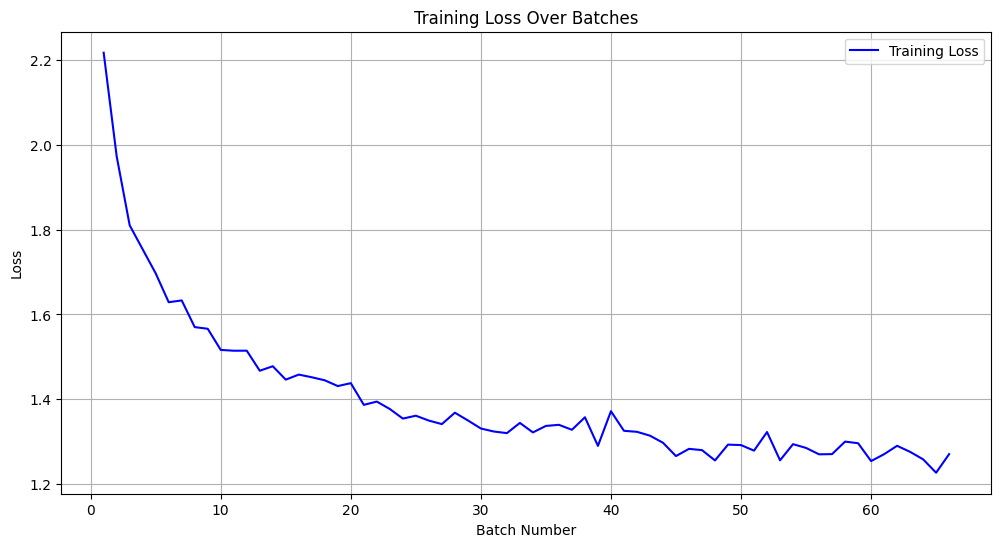

In [41]:
import matplotlib.pyplot as plt

# Loss values from your training output
losses = [
    2.2174, 1.9729, 1.8102, 1.7535, 1.6969, 1.6288, 1.6331, 1.5701, 1.5662,
    1.5163, 1.5144, 1.5145, 1.4672, 1.4778, 1.4462, 1.4581, 1.4518, 1.4446,
    1.4310, 1.4379, 1.3867, 1.3944, 1.3769, 1.3543, 1.3611, 1.3496, 1.3413,
    1.3682, 1.3500, 1.3309, 1.3238, 1.3200, 1.3441, 1.3217, 1.3370, 1.3396,
    1.3279, 1.3574, 1.2899, 1.3717, 1.3255, 1.3231, 1.3140, 1.2973, 1.2659,
    1.2829, 1.2799, 1.2556, 1.2929, 1.2918, 1.2787, 1.3226, 1.2559, 1.2940,
    1.2851, 1.2700, 1.2705, 1.3000, 1.2962, 1.2541, 1.2703, 1.2901, 1.2758,
    1.2582, 1.2266, 1.2705
]

# Create a list of epochs
batches = list(range(1, len(losses) + 1))

# Plotting the losses
plt.figure(figsize=(12, 6))
plt.plot(batches, losses, label='Training Loss', color='blue')
plt.title('Training Loss Over Batches')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


# LOADING RESNET-101

In [47]:
from torchvision import models

resnet_model = models.resnet101(pretrained=True)

# Freeze the feature extractor backbone
for param in resnet_model.parameters():
    param.requires_grad = False


resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
resnet_model = resnet_model.to(device)

# Step 3: Define optimizer and loss function for fine-tuning
optimizer = optim.AdamW(resnet_model.parameters(), lr=0.001)  # Using AdamW optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification

# Training Resnet101

In [48]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Step 4: Fine-tune the ResNet model
num_epochs = 3  # Feel free to adjust the number of epochs

# List to store the loss values
loss_values = []
average_losses = []  # List to store average losses every 100 batches

for epoch in range(num_epochs):
    resnet_model.train()  # Set the model to training mode
    running_loss = 0.0

    # Create a tqdm wrapper for the DataLoader
    progress_bar = tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f'Epoch {epoch + 1}/{num_epochs}')

    for i, data in progress_bar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Store loss for every batch
        loss_values.append(loss.item())

        # Update the progress bar with the current loss
        if (i + 1) % 100 == 0:  # Update every 100 mini-batches
            avg_loss = running_loss / 100
            average_losses.append(avg_loss)  # Store average loss
            print(f'Batch [{i + 1}], Average Loss: {avg_loss:.4f}')  # Print average loss
            running_loss = 0.0  # Reset running loss for the next 100 batches

    # Optional: At the end of each epoch, you can print the epoch's average loss
    print(f'Epoch [{epoch + 1}/{num_epochs}] completed.')

print('Training complete.')

# Now the average_losses array holds the average loss for every 100 batches




Epoch 1/3:   4%|▍         | 101/2290 [00:16<05:49,  6.27it/s]

Batch [100], Average Loss: 2.1866


Epoch 1/3:   9%|▉         | 201/2290 [00:32<05:39,  6.15it/s]

Batch [200], Average Loss: 2.0354


Epoch 1/3:  13%|█▎        | 301/2290 [00:48<05:29,  6.03it/s]

Batch [300], Average Loss: 1.9716


Epoch 1/3:  18%|█▊        | 401/2290 [01:05<05:14,  6.01it/s]

Batch [400], Average Loss: 1.9332


Epoch 1/3:  22%|██▏       | 501/2290 [01:21<04:55,  6.06it/s]

Batch [500], Average Loss: 1.9117


Epoch 1/3:  26%|██▌       | 601/2290 [01:38<04:34,  6.16it/s]

Batch [600], Average Loss: 1.9153


Epoch 1/3:  31%|███       | 701/2290 [01:54<04:17,  6.17it/s]

Batch [700], Average Loss: 1.8509


Epoch 1/3:  35%|███▍      | 801/2290 [02:10<04:04,  6.10it/s]

Batch [800], Average Loss: 1.8598


Epoch 1/3:  39%|███▉      | 901/2290 [02:27<03:48,  6.07it/s]

Batch [900], Average Loss: 1.8925


Epoch 1/3:  44%|████▎     | 1001/2290 [02:43<03:33,  6.04it/s]

Batch [1000], Average Loss: 1.8872


Epoch 1/3:  48%|████▊     | 1101/2290 [02:59<03:13,  6.13it/s]

Batch [1100], Average Loss: 1.7753


Epoch 1/3:  52%|█████▏    | 1201/2290 [03:16<02:58,  6.10it/s]

Batch [1200], Average Loss: 1.8164


Epoch 1/3:  57%|█████▋    | 1301/2290 [03:32<02:42,  6.09it/s]

Batch [1300], Average Loss: 1.8023


Epoch 1/3:  61%|██████    | 1401/2290 [03:48<02:25,  6.11it/s]

Batch [1400], Average Loss: 1.7861


Epoch 1/3:  66%|██████▌   | 1501/2290 [04:05<02:09,  6.09it/s]

Batch [1500], Average Loss: 1.8198


Epoch 1/3:  70%|██████▉   | 1601/2290 [04:21<01:53,  6.05it/s]

Batch [1600], Average Loss: 1.8115


Epoch 1/3:  74%|███████▍  | 1701/2290 [04:37<01:36,  6.07it/s]

Batch [1700], Average Loss: 1.7939


Epoch 1/3:  79%|███████▊  | 1801/2290 [04:54<01:20,  6.05it/s]

Batch [1800], Average Loss: 1.7938


Epoch 1/3:  83%|████████▎ | 1901/2290 [05:10<01:03,  6.11it/s]

Batch [1900], Average Loss: 1.7961


Epoch 1/3:  87%|████████▋ | 2001/2290 [05:27<00:47,  6.07it/s]

Batch [2000], Average Loss: 1.8214


Epoch 1/3:  92%|█████████▏| 2101/2290 [05:43<00:31,  6.08it/s]

Batch [2100], Average Loss: 1.7821


Epoch 1/3:  96%|█████████▌| 2201/2290 [05:59<00:14,  6.06it/s]

Batch [2200], Average Loss: 1.7855


Epoch 1/3: 100%|██████████| 2290/2290 [06:14<00:00,  6.11it/s]

Epoch [1/3] completed.



Epoch 2/3:   4%|▍         | 101/2290 [00:16<06:00,  6.08it/s]

Batch [100], Average Loss: 1.7552


Epoch 2/3:   9%|▉         | 201/2290 [00:32<05:43,  6.08it/s]

Batch [200], Average Loss: 1.7518


Epoch 2/3:  13%|█▎        | 301/2290 [00:49<05:25,  6.11it/s]

Batch [300], Average Loss: 1.7694


Epoch 2/3:  18%|█▊        | 401/2290 [01:05<05:08,  6.12it/s]

Batch [400], Average Loss: 1.7782


Epoch 2/3:  22%|██▏       | 501/2290 [01:22<04:55,  6.06it/s]

Batch [500], Average Loss: 1.7596


Epoch 2/3:  26%|██▌       | 601/2290 [01:38<04:36,  6.12it/s]

Batch [600], Average Loss: 1.7755


Epoch 2/3:  31%|███       | 701/2290 [01:54<04:20,  6.10it/s]

Batch [700], Average Loss: 1.7653


Epoch 2/3:  35%|███▍      | 801/2290 [02:11<04:02,  6.15it/s]

Batch [800], Average Loss: 1.8033


Epoch 2/3:  39%|███▉      | 901/2290 [02:27<03:47,  6.10it/s]

Batch [900], Average Loss: 1.7522


Epoch 2/3:  44%|████▎     | 1001/2290 [02:43<03:31,  6.10it/s]

Batch [1000], Average Loss: 1.8165


Epoch 2/3:  48%|████▊     | 1101/2290 [03:00<03:15,  6.08it/s]

Batch [1100], Average Loss: 1.7248


Epoch 2/3:  52%|█████▏    | 1201/2290 [03:16<02:58,  6.09it/s]

Batch [1200], Average Loss: 1.7831


Epoch 2/3:  57%|█████▋    | 1301/2290 [03:32<02:41,  6.12it/s]

Batch [1300], Average Loss: 1.7612


Epoch 2/3:  61%|██████    | 1401/2290 [03:49<02:25,  6.11it/s]

Batch [1400], Average Loss: 1.7705


Epoch 2/3:  66%|██████▌   | 1501/2290 [04:05<02:09,  6.11it/s]

Batch [1500], Average Loss: 1.7189


Epoch 2/3:  70%|██████▉   | 1601/2290 [04:22<01:52,  6.13it/s]

Batch [1600], Average Loss: 1.7502


Epoch 2/3:  74%|███████▍  | 1701/2290 [04:38<01:36,  6.09it/s]

Batch [1700], Average Loss: 1.7502


Epoch 2/3:  79%|███████▊  | 1801/2290 [04:54<01:20,  6.09it/s]

Batch [1800], Average Loss: 1.7651


Epoch 2/3:  83%|████████▎ | 1901/2290 [05:11<01:03,  6.09it/s]

Batch [1900], Average Loss: 1.7562


Epoch 2/3:  87%|████████▋ | 2001/2290 [05:27<00:47,  6.11it/s]

Batch [2000], Average Loss: 1.7655


Epoch 2/3:  92%|█████████▏| 2101/2290 [05:43<00:30,  6.12it/s]

Batch [2100], Average Loss: 1.7594


Epoch 2/3:  96%|█████████▌| 2201/2290 [06:00<00:14,  6.10it/s]

Batch [2200], Average Loss: 1.7588


Epoch 2/3: 100%|██████████| 2290/2290 [06:14<00:00,  6.11it/s]

Epoch [2/3] completed.



Epoch 3/3:   4%|▍         | 101/2290 [00:16<05:58,  6.11it/s]

Batch [100], Average Loss: 1.7553


Epoch 3/3:   9%|▉         | 201/2290 [00:32<05:40,  6.13it/s]

Batch [200], Average Loss: 1.7108


Epoch 3/3:  13%|█▎        | 301/2290 [00:49<05:26,  6.09it/s]

Batch [300], Average Loss: 1.6907


Epoch 3/3:  18%|█▊        | 401/2290 [01:05<05:08,  6.13it/s]

Batch [400], Average Loss: 1.7244


Epoch 3/3:  22%|██▏       | 501/2290 [01:22<04:57,  6.02it/s]

Batch [500], Average Loss: 1.7414


Epoch 3/3:  26%|██▌       | 601/2290 [01:38<04:38,  6.07it/s]

Batch [600], Average Loss: 1.7443


Epoch 3/3:  31%|███       | 701/2290 [01:54<04:20,  6.09it/s]

Batch [700], Average Loss: 1.7240


Epoch 3/3:  35%|███▍      | 801/2290 [02:11<04:04,  6.08it/s]

Batch [800], Average Loss: 1.7474


Epoch 3/3:  39%|███▉      | 901/2290 [02:27<03:47,  6.10it/s]

Batch [900], Average Loss: 1.7458


Epoch 3/3:  44%|████▎     | 1001/2290 [02:43<03:30,  6.11it/s]

Batch [1000], Average Loss: 1.7715


Epoch 3/3:  48%|████▊     | 1101/2290 [03:00<03:14,  6.13it/s]

Batch [1100], Average Loss: 1.7385


Epoch 3/3:  52%|█████▏    | 1201/2290 [03:16<02:57,  6.14it/s]

Batch [1200], Average Loss: 1.7183


Epoch 3/3:  57%|█████▋    | 1301/2290 [03:32<02:41,  6.11it/s]

Batch [1300], Average Loss: 1.7197


Epoch 3/3:  61%|██████    | 1401/2290 [03:49<02:25,  6.12it/s]

Batch [1400], Average Loss: 1.7370


Epoch 3/3:  66%|██████▌   | 1501/2290 [04:05<02:09,  6.10it/s]

Batch [1500], Average Loss: 1.7162


Epoch 3/3:  70%|██████▉   | 1601/2290 [04:22<01:52,  6.14it/s]

Batch [1600], Average Loss: 1.7367


Epoch 3/3:  74%|███████▍  | 1701/2290 [04:38<01:36,  6.12it/s]

Batch [1700], Average Loss: 1.7279


Epoch 3/3:  79%|███████▊  | 1801/2290 [04:54<01:19,  6.13it/s]

Batch [1800], Average Loss: 1.6867


Epoch 3/3:  83%|████████▎ | 1901/2290 [05:11<01:03,  6.09it/s]

Batch [1900], Average Loss: 1.7081


Epoch 3/3:  87%|████████▋ | 2001/2290 [05:27<00:47,  6.09it/s]

Batch [2000], Average Loss: 1.7238


Epoch 3/3:  92%|█████████▏| 2101/2290 [05:43<00:30,  6.10it/s]

Batch [2100], Average Loss: 1.7502


Epoch 3/3:  96%|█████████▌| 2201/2290 [06:00<00:14,  6.15it/s]

Batch [2200], Average Loss: 1.7140


Epoch 3/3: 100%|██████████| 2290/2290 [06:14<00:00,  6.11it/s]

Epoch [3/3] completed.
Training complete.


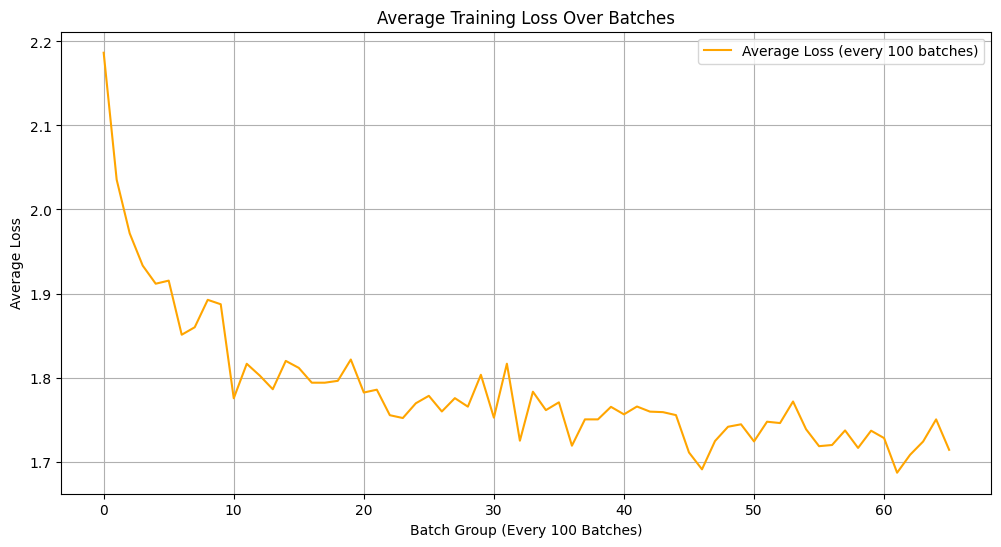

In [49]:
# Plot the average losses
plt.figure(figsize=(12, 6))
plt.plot(average_losses, label='Average Loss (every 100 batches)', color='orange')
plt.title('Average Training Loss Over Batches')
plt.xlabel('Batch Group (Every 100 Batches)')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

# Testing Resnet-50

In [50]:
from tqdm import tqdm

# Step 5: Evaluate the fine-tuned ResNet model
resnet_model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

# Create a tqdm wrapper for the testloader
progress_bar = tqdm(testloader, total=len(testloader), desc='Evaluating')

with torch.no_grad():
    for data in progress_bar:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar with the current accuracy
        progress_bar.set_postfix({'Accuracy': f'{100 * correct / total:.2f}%'})

accuracy = 100 * correct / total
print(f'Accuracy of fine-tuned ResNet on test images: {accuracy:.2f}%')


Evaluating: 100%|██████████| 814/814 [02:07<00:00,  6.37it/s, Accuracy=43.11%]

Accuracy of fine-tuned ResNet on test images: 43.11%


# Loading CLIP-VIT-BASE

In [21]:
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

svhn_clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
svhn_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

svhn_clip.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

# Creating Test Dataloader for clip model

In [26]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
     transforms.ToTensor()
])
def custom_collate_fn(batch):
    images, labels = zip(*batch)  # Unzip the batch into images and labels
    labels = torch.tensor(labels)  # Convert labels to a tensor
    return list(images), labels    # Return images as a list and labels as a tensor

svhn_test_dataset = torchvision.datasets.SVHN(root='./data', split="test", transform = test_transform, download=True)
test_dataloader = DataLoader(svhn_test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

Using downloaded and verified file: ./data/test_32x32.mat


In [27]:
class_names = ["0","1","2","3","4","5","6","7""8","9"]

text_inputs = svhn_processor(text=[f"A photo of a {label}" for label in class_names], return_tensors="pt", padding=True).to(device)

# Zero shot evaluation by CLIP on SVHN

In [28]:
# Zero-shot evaluation on the test dataset with accuracy computation
def zse_of_clip_on_svhn(test_loader, model, labels):
    correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating", leave=False):
            images = [img.to(device) for img in images]  
            targets = targets.to(device)

            # Process inputs for the CLIP model
            inputs = svhn_processor(text=labels, images=images, return_tensors="pt", padding=True, do_rescale=False).to(device)

            # Forward pass
            outputs = model(**inputs)

            # Get image-text similarity scores
            logits_per_image = outputs.logits_per_image  

            # Compute probabilities using softmax
            probs = logits_per_image.softmax(dim=1)

            # Get predicted labels (as indices)
            preds = torch.argmax(probs, dim=1)

            # Calculate accuracy
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    accuracy = correct / total * 100
    return accuracy

accuracy = zse_of_clip_on_svhn(test_dataloader, svhn_clip, class_names)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 41.23%
